<a href="https://colab.research.google.com/github/gyanasluitel/Music_Genre_Classification/blob/main/notebooks/CNN_final_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [410]:
from sklearn.metrics import classification_report

In [2]:
import math

In [3]:
import librosa

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pickle

In [6]:
import keras

In [7]:
from keras import layers, Sequential
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
df_path= os.getcwd()+'/drive/MyDrive/Sub_Data/data.pickle'

In [10]:
df = pd.read_pickle(df_path)
df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,Labels
0,-536.042786,32.067459,-49.450306,25.776079,-11.531991,-18.413410,-8.967739,-4.582458,-0.501133,6.618028,12.905916,6.469436,12.735432,reggae
1,-392.235077,28.644016,-73.791199,50.155655,1.933116,-14.058987,1.360568,-14.130725,-4.516984,-18.869156,12.337111,0.084416,-19.625988,reggae
2,-451.695129,17.615837,-53.177261,43.919796,28.546822,-8.240944,3.578257,-8.234414,-9.060442,-26.781670,-4.912760,1.545562,-2.422036,reggae
3,-477.528839,33.314350,-58.991947,36.357792,26.536734,-0.675872,1.368691,-16.134178,-0.317810,-8.654249,-9.246617,-24.636469,-10.302074,reggae
4,-504.078796,35.871197,-48.558861,50.370205,2.761873,-12.647474,7.050649,-2.322120,-6.039096,-31.120485,-4.710315,-3.640983,-0.203701,reggae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298175,-455.102631,24.158625,-63.375328,65.074524,3.704499,40.963463,-21.325134,10.105320,-16.304668,-9.928100,-23.563305,4.619114,15.669947,blues
1298176,-447.722656,2.117634,-44.335674,58.148350,12.036886,21.317839,-22.656757,19.766155,-27.212273,-20.932671,-30.610203,16.540192,9.672492,blues
1298177,-449.050079,10.812412,-50.106941,54.213680,1.793259,21.684978,-25.272818,8.188376,-16.318310,9.493264,-36.492809,12.093601,3.433430,blues
1298178,-437.535187,12.875460,-50.128567,54.451469,7.296531,35.563461,-19.915752,4.126825,-17.346703,5.894392,-34.753819,12.200981,-2.462997,blues


In [11]:
def process_df(df):
    '''
    Input: dataframe object
    Output: returns a 3d nparray
    '''
    inputs = df.iloc[0*130:0+1*130,:-1] #getting the first 130 rows
    inputs = np.expand_dims(inputs,0)   #expanding the shape of the array by inserting a new axis at the first position
    targets= [df.iloc[0*130,-1]]
    for i in range(1, int(df.shape[0]/130)): #repeating the above process for the entirety of the remaining dataset
        dummy_x = df.iloc[i*130:(i+1)*130, :-1].values
        dummy_x = np.expand_dims(dummy_x,0)
        dummy_y = df.iloc[i*130,-1]
        inputs = np.concatenate((inputs, dummy_x), axis=0)
        targets.append(dummy_y)
    return inputs, targets

In [12]:
def split_data(df, test_size, validation_size):
    '''
    Input: A dataframe
    Ouput: return the train, test and validation set 
    '''
    # inputs, targets = process_df(df)
    # encoder = LabelEncoder()
    # targets = encoder.fit_transform(targets) #encoded the categorical values in our target class 

    #Splitting data into train and test sets
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size = test_size)

    #Splitting train data into train and validation sets
    inputs_train, inputs_validation, targets_train, targets_validation = train_test_split(inputs_train, targets_train, test_size = validation_size)

    #adding an axis to input sets
    inputs_train = np.expand_dims(inputs_train,-1)
    inputs_validation = np.expand_dims(inputs_validation,-1)
    inputs_test = np.expand_dims(inputs_test,-1)

    return inputs_train, inputs_validation, inputs_test, targets_train, targets_validation, targets_test


In [13]:
def build_model(input_shape):
    '''Generates CNN model'''

    #build network topology
    model = keras.Sequential()

    #1st convolutional layer
    model.add(keras.layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides = (2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    #2st convolutional layer
    model.add(keras.layers.Conv2D(32,(3,3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D((3,3), strides = (2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    #3rd convolutional layer
    model.add(keras.layers.Conv2D(32,(2,2), activation ='relu'))
    model.add(keras.layers.MaxPooling2D((2,2), strides = (2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    #flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [14]:
if __name__ == '__main__':
    inputs, targets = process_df(df)
    encoder = LabelEncoder()
    targets = encoder.fit_transform(targets) #encoded the categorical values in our target class 

    #get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(df, 0.25,0.2)
    print(f'Shape of X_train: {X_train.shape}')
    print(f'Shape of X_train: {X_validation.shape}')
    print(f'Shape of X_train: {X_test.shape}')

    #create network 
    input_shape = (X_train.shape[1], X_train.shape[2],1)
    model = build_model(input_shape)

    #compile model
    optimiser = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimiser, 
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    model.summary()

    #train modle
    history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), batch_size=32,  epochs = 50)

Shape of X_train: (5991, 130, 13, 1)
Shape of X_train: (1498, 130, 13, 1)
Shape of X_train: (2497, 130, 13, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
___________

In [15]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(10,10))
        

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 20})
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 20})
    axs[1].set_title("Error eval")
    fig.tight_layout(pad=3.0)
    plt.savefig('cnn_train_test_accuracy2.png')
    plt.show()



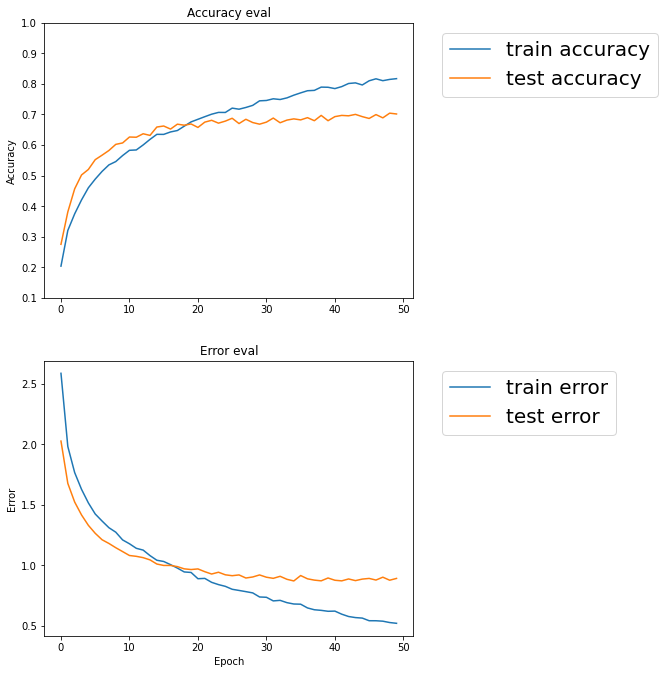

In [16]:
plot_history(history)

#Saving CNN Model

In [17]:
import pickle 
import os

In [18]:
model_path = os.path.join(os.getcwd(), 'drive/Sub_Data')

In [19]:
model_path

'/content/drive/Sub_Data'

In [20]:
model.save('cnn_model_mfcc13_2.h5')

#Making Predictions

In [22]:
# inputs, targets = process_df(df)
# encoder = LabelEncoder()
# targets = encoder.fit_transform(targets) #encoded the categorical values in our target class 


In [23]:
def make_prediction(model, X, y):
    #adding a dimension to input data since model.predict() expects a 4d array as input
    X_to_predict= np.expand_dims(X,0)
    # inputs, targets = process_df(df)
    # encoder = LabelEncoder()
    # targets = encoder.fit_transform(targets)

    #perfrom predicition
    prediction = model.predict(X_to_predict)
    predicted_index = np.argmax(prediction, axis=1)
    predicted_output = encoder.inverse_transform([predicted_index])[0]
    print(f'Original Label: {encoder.inverse_transform([y_to_predict])[0]} \n Predicted Output: {predicted_output}')
    #get index with ma 

In [24]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: blues 
 Predicted Output: blues


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[600]
y_to_predict = y_test[600]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: blues 
 Predicted Output: rock


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[-1]
y_to_predict = y_test[-1]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: country 
 Predicted Output: disco


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[232]
y_to_predict = y_test[232]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: classical 
 Predicted Output: classical


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
#Making prediction - picking a sample to predict from the test set
X_to_predict = X_test[1948]
y_to_predict = y_test[1948]

make_prediction(model, X_to_predict, y_to_predict)

Original Label: country 
 Predicted Output: country


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
#Evalution model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 2)
print(f'Test Accuracy: {test_acc}')

79/79 - 1s - loss: 0.9307 - accuracy: 0.6856
Test Accuracy: 0.6856227517127991


In [415]:
encoder.inverse_transform(np.unique(targets))

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [414]:
#Classification Report
predictions = model.predict(X_test)
predicted_indexes= np.argmax(predictions, axis=1)
print(classification_report(y_test, predicted_indexes))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       277
           1       0.92      0.90      0.91       278
           2       0.53      0.61      0.57       232
           3       0.65      0.48      0.55       250
           4       0.66      0.67      0.67       259
           5       0.82      0.75      0.78       236
           6       0.79      0.83      0.81       254
           7       0.70      0.72      0.71       240
           8       0.61      0.62      0.62       231
           9       0.48      0.45      0.47       240

    accuracy                           0.69      2497
   macro avg       0.68      0.68      0.68      2497
weighted avg       0.69      0.69      0.68      2497

